In [2]:
import pandas as pd

In [3]:
# Dataset da variavel target
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/dd201a034223a16732c6f639b40600b26bd3129c/dados/clientes_aprovados.csv')

# Dataset tratado no primeiro script
df_cadastrados = pd.read_csv('../../dados/credit_score/clientes_cadastrados_clean.csv')

In [4]:
# ID Cliente -> Join com df_cadastrados
# Mes_referencia -> 0 = mês atual, -1 = mês passado, etc.
# Faixa_atraso -> quanto tempo atrasou o pagamento
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [5]:
# Valores possíveis para Faixa_atraso
df_aprovados['Faixa_atraso'].value_counts()

Faixa_atraso
pagamento realizado    442031
1-29 dias              383120
nenhum empréstimo      209230
30-59 dias              11090
>150 dias                1693
60-89 dias                868
90-119 dias               320
120-149 dias              223
Name: count, dtype: int64

In [6]:
# Exemplo de linhas para um cliente específico
df_aprovados.loc[df_aprovados['ID_Cliente'] == 5001712]

,ID_Cliente,Mes_referencia,Faixa_atraso
4,5001712,0,pagamento realizado
5,5001712,-1,pagamento realizado
6,5001712,-2,pagamento realizado
7,5001712,-3,pagamento realizado
8,5001712,-4,pagamento realizado
9,5001712,-5,pagamento realizado
10,5001712,-6,pagamento realizado
11,5001712,-7,pagamento realizado
12,5001712,-8,pagamento realizado
13,5001712,-9,1-29 dias


**Variável target**: cliente é bom ou mau pagador?

Isso requere etapa de feature engineering, ponderar diversos fatores!

# Feature Engineering

## Mês de abertura e fechamento das contas

In [7]:
df_goupby_id = df_aprovados.groupby('ID_Cliente').agg(Mes_inicio_conta=('Mes_referencia','min'), Mes_fim_conta = ('Mes_referencia','max')).reset_index()
df_goupby_id

,ID_Cliente,Mes_inicio_conta,Mes_fim_conta
0,5001711,-3,0
1,5001712,-18,0
2,5001713,-21,0
3,5001714,-14,0
4,5001715,-59,0
...,...,...,...
45980,5150482,-28,-11
45981,5150483,-17,0
45982,5150484,-12,0
45983,5150485,-1,0


In [8]:
# Merge no df aprovados
df_aprovados_mes = df_aprovados.merge(df_goupby_id, on='ID_Cliente')
df_aprovados_mes

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta
0,5001711,0,nenhum empréstimo,-3,0
1,5001711,-1,1-29 dias,-3,0
2,5001711,-2,1-29 dias,-3,0
3,5001711,-3,1-29 dias,-3,0
4,5001712,0,pagamento realizado,-18,0
...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0
1048571,5150487,-26,pagamento realizado,-29,0
1048572,5150487,-27,pagamento realizado,-29,0
1048573,5150487,-28,pagamento realizado,-29,0


## Número de meses

In [9]:
df_aprovados_mes['N_meses'] = df_aprovados_mes['Mes_fim_conta'] - df_aprovados_mes['Mes_inicio_conta']

In [10]:
df_aprovados_mes

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses
0,5001711,0,nenhum empréstimo,-3,0,3
1,5001711,-1,1-29 dias,-3,0,3
2,5001711,-2,1-29 dias,-3,0,3
3,5001711,-3,1-29 dias,-3,0,3
4,5001712,0,pagamento realizado,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29
1048571,5150487,-26,pagamento realizado,-29,0,29
1048572,5150487,-27,pagamento realizado,-29,0,29
1048573,5150487,-28,pagamento realizado,-29,0,29


## MOB

Months on Book -> para cada mês de referência, indica há quantos meses o relacionamento com o cliente se iniciou

MOB = Mes_referencia - Mes_inicio_conta

In [11]:
df_aprovados_mob = df_aprovados_mes.copy()

In [12]:
df_aprovados_mob['MOB'] = df_aprovados_mob['Mes_referencia'] - df_aprovados_mob['Mes_inicio_conta']

In [13]:
df_aprovados_mob

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB
0,5001711,0,nenhum empréstimo,-3,0,3,3
1,5001711,-1,1-29 dias,-3,0,3,2
2,5001711,-2,1-29 dias,-3,0,3,1
3,5001711,-3,1-29 dias,-3,0,3,0
4,5001712,0,pagamento realizado,-18,0,18,18
...,...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29,4
1048571,5150487,-26,pagamento realizado,-29,0,29,3
1048572,5150487,-27,pagamento realizado,-29,0,29,2
1048573,5150487,-28,pagamento realizado,-29,0,29,1


## Cliente ativo

In [14]:
df_aprovados_mob['Cliente_ativo'] = df_aprovados_mob['Mes_fim_conta'].apply(lambda x: 1 if x == 0 else 0)

In [15]:
df_aprovados_mob

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo
0,5001711,0,nenhum empréstimo,-3,0,3,3,1
1,5001711,-1,1-29 dias,-3,0,3,2,1
2,5001711,-2,1-29 dias,-3,0,3,1,1
3,5001711,-3,1-29 dias,-3,0,3,0,1
4,5001712,0,pagamento realizado,-18,0,18,18,1
...,...,...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29,4,1
1048571,5150487,-26,pagamento realizado,-29,0,29,3,1
1048572,5150487,-27,pagamento realizado,-29,0,29,2,1
1048573,5150487,-28,pagamento realizado,-29,0,29,1,1


## Faixa_atraso

Mudar Faixa_atraso para valores numéricos

In [16]:
df_aprovados_faixa_atraso = df_aprovados_mob.copy()

In [17]:
df_aprovados_faixa_atraso['Faixa_atraso'].unique()

array(['nenhum empréstimo', '1-29 dias', 'pagamento realizado',
       '30-59 dias', '60-89 dias', '90-119 dias', '120-149 dias',
       '>150 dias'], dtype=object)

In [18]:
dict_faixa_atraso = {'nenhum empréstimo':0, 'pagamento realizado':1,'1-29 dias':2,
       '30-59 dias':3, '60-89 dias':4, '90-119 dias':5, '120-149 dias':6,
       '>150 dias':7}

In [19]:
df_aprovados_faixa_atraso['Int_Faixa_atraso'] = df_aprovados_faixa_atraso['Faixa_atraso'].map(dict_faixa_atraso)
df_aprovados_faixa_atraso.drop(columns=['Faixa_atraso'], inplace=True)
df_aprovados_faixa_atraso.rename(columns={'Int_Faixa_atraso':'Faixa_atraso'}, inplace=True)

## Variável Bom/Mau pagador

In [20]:
df_aprovados_pagadores = df_aprovados_faixa_atraso.copy()

In [21]:
df_aprovados_pagadores['Mau_pagador'] = df_aprovados_pagadores['Faixa_atraso'].apply(lambda x: 1 if x > 2 else 0)

In [22]:
df_aprovados_pagadores

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0
1,5001711,-1,-3,0,3,2,1,2,0
2,5001711,-2,-3,0,3,1,1,2,0
3,5001711,-3,-3,0,3,0,1,2,0
4,5001712,0,-18,0,18,18,1,1,0
...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,-29,0,29,4,1,1,0
1048571,5150487,-26,-29,0,29,3,1,1,0
1048572,5150487,-27,-29,0,29,2,1,1,0
1048573,5150487,-28,-29,0,29,1,1,1,0


## Número de vezes que foi mau pagador

In [23]:
df_groupby_n_mau_pagador = df_aprovados_pagadores.groupby('ID_Cliente').agg(N_Mau_pagador = ('Mau_pagador','sum')).reset_index()
df_groupby_n_mau_pagador

,ID_Cliente,N_Mau_pagador
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [24]:
df_aprovados_pagadores = df_aprovados_pagadores.merge(df_groupby_n_mau_pagador, on='ID_Cliente')

In [25]:
df_aprovados_pagadores

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0,0
1,5001711,-1,-3,0,3,2,1,2,0,0
2,5001711,-2,-3,0,3,1,1,2,0,0
3,5001711,-3,-3,0,3,0,1,2,0,0
4,5001712,0,-18,0,18,18,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,-29,0,29,4,1,1,0,0
1048571,5150487,-26,-29,0,29,3,1,1,0,0
1048572,5150487,-27,-29,0,29,2,1,1,0,0
1048573,5150487,-28,-29,0,29,1,1,1,0,0


## Proporção de meses como mau pagador

In [26]:
df_aprovados_pagadores['Ratio_Mau_pagador'] = df_aprovados_pagadores.apply(lambda x: (x['N_Mau_pagador'] / x['N_meses']) * 100 if x['N_meses'] > 0 else 0, axis=1)

In [27]:
df_aprovados_pagadores['Ratio_Mau_pagador'].value_counts()

Ratio_Mau_pagador
0.000000     904765
5.263158       2682
5.000000       2647
7.142857       2596
5.882353       2530
              ...  
92.857143        15
53.846154        14
84.615385        14
72.727273        12
87.500000         9
Name: count, Length: 395, dtype: int64

## Análise Vintage

### Qtd de clientes por Mes Inicio Conta

In [30]:
# Criação de DF com ID_Clientes unicos, considerando apenas o mês mais atual de registro
df_clientes_drop_duplicates = df_aprovados_pagadores.drop_duplicates(subset='ID_Cliente', keep='first')
df_clientes_drop_duplicates.reset_index(drop=True, inplace=True)
df_clientes_drop_duplicates

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0,0,0.0
1,5001712,0,-18,0,18,18,1,1,0,0,0.0
2,5001713,0,-21,0,21,21,1,0,0,0,0.0
3,5001714,0,-14,0,14,14,1,0,0,0,0.0
4,5001715,0,-59,0,59,59,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,-11,-28,-11,17,17,0,1,0,0,0.0
45981,5150483,0,-17,0,17,17,1,0,0,0,0.0
45982,5150484,0,-12,0,12,12,1,1,0,0,0.0
45983,5150485,0,-1,0,1,1,1,2,0,0,0.0


In [35]:
# Contagem de clientes únicos em cada valor de 
df_abertura = df_clientes_drop_duplicates.groupby('Mes_inicio_conta').agg({'ID_Cliente':'count'}).reset_index()
df_abertura.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_abertura

,Mes_inicio_conta,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [61]:
# Criação de DF Vintage: Agrupamento por Mes Inicio Conta e MOB (Months on Book)
df_vintage = df_aprovados_pagadores.groupby(['Mes_inicio_conta','MOB']).agg({'ID_Cliente':'count'}).reset_index()
df_vintage.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403
...,...,...,...
1886,-2,1,770
1887,-2,2,750
1888,-1,0,686
1889,-1,1,682


In [36]:
## Isso não parece correto, vou desconsiderar!


# Merge df vintage e df abertura
df_vintage = df_vintage[['Mes_inicio_conta','MOB']].merge(df_abertura, on='Mes_inicio_conta', how='left')
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


### Proporção maus pagadores

In [37]:
import numpy as np

df_vintage['Qtde_Mau_pagador'] = np.nan

In [60]:
df_aprovados_pagadores.loc[(df_aprovados_pagadores['Mes_inicio_conta'] == -60) & (df_aprovados_pagadores['MOB'] == 60)]

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador
377,5001730,0,-60,0,60,60,1,1,0,0,0.000000
9696,5002160,0,-60,0,60,60,1,2,0,0,0.000000
9869,5002165,0,-60,0,60,60,1,2,0,0,0.000000
9976,5002171,0,-60,0,60,60,1,1,0,0,0.000000
12322,5002283,0,-60,0,60,60,1,1,0,2,3.333333
...,...,...,...,...,...,...,...,...,...,...,...
1000847,5143482,0,-60,0,60,60,1,1,0,0,0.000000
1004969,5145767,0,-60,0,60,60,1,2,0,0,0.000000
1013592,5146385,0,-60,0,60,60,1,1,0,0,0.000000
1018288,5148524,0,-60,0,60,60,1,1,0,0,0.000000


In [66]:
for j in sorted(df_vintage['Mes_inicio_conta'].unique()):
    ls = []

    for i in range(0, len(df_vintage['Mes_inicio_conta'].unique()) +1):
        due = list(df_aprovados_pagadores.query("Mau_pagador == 1 and MOB == @i and Mes_inicio_conta == @j")['ID_Cliente'])

        n_mau_pagadores = len(due)

        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Mes_inicio_conta'] == j), 'Qtde_Mau_pagador'] = n_mau_pagadores


df_vintage['Taxa_Mau_pagador'] = df_vintage['Qtde_Mau_pagador'] / df_vintage['Qtd_Clientes'] * 100

### Tabela Pivot

In [74]:
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes,Qtde_Mau_pagador,Taxa_Mau_pagador
0,-60,0,415,0.0,0.000000
1,-60,1,414,2.0,0.483092
2,-60,2,410,6.0,1.463415
3,-60,3,408,5.0,1.225490
4,-60,4,403,9.0,2.233251
...,...,...,...,...,...
1886,-2,1,770,14.0,1.818182
1887,-2,2,750,14.0,1.866667
1888,-1,0,686,2.0,0.291545
1889,-1,1,682,10.0,1.466276


In [73]:
df_vintage_pivot = df_vintage.pivot(index='Mes_inicio_conta', columns='MOB', values='Taxa_Mau_pagador')
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Mes_inicio_conta,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.483092,1.463415,1.225490,2.233251,2.238806,2.500000,3.299492,2.827763,2.631579,...,1.282051,0.862069,0.881057,1.321586,0.881057,1.333333,1.333333,1.339286,1.339286,2.252252
-59,0.246305,1.234568,1.745636,2.512563,2.791878,2.557545,2.583979,2.590674,2.083333,3.157895,...,0.763359,1.923077,1.976285,1.190476,2.000000,2.032520,1.244813,1.260504,0.862069,NaN
-58,0.000000,1.136364,1.141553,1.157407,1.176471,1.184834,2.877698,1.699029,1.231527,2.000000,...,0.790514,0.000000,0.000000,0.400000,0.401606,0.000000,0.406504,0.423729,NaN,NaN
-57,0.000000,1.500000,1.269036,2.295918,2.343750,1.832461,2.400000,1.621622,2.185792,4.972376,...,0.843882,1.276596,0.851064,0.862069,1.304348,0.873362,0.892857,NaN,NaN,NaN
-56,0.000000,1.914894,1.927195,2.783726,2.164502,2.178649,2.660754,2.672606,3.611738,3.440367,...,0.337838,0.000000,0.000000,0.000000,0.348432,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.000000,0.801833,2.317497,2.948113,2.400960,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.000000,1.635769,1.659292,1.475596,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.000000,1.818182,1.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
import seaborn as sns

In [84]:
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Mes_inicio_conta,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.483092,1.463415,1.225490,2.233251,2.238806,2.500000,3.299492,2.827763,2.631579,...,1.282051,0.862069,0.881057,1.321586,0.881057,1.333333,1.333333,1.339286,1.339286,2.252252
-59,0.246305,1.234568,1.745636,2.512563,2.791878,2.557545,2.583979,2.590674,2.083333,3.157895,...,0.763359,1.923077,1.976285,1.190476,2.000000,2.032520,1.244813,1.260504,0.862069,NaN
-58,0.000000,1.136364,1.141553,1.157407,1.176471,1.184834,2.877698,1.699029,1.231527,2.000000,...,0.790514,0.000000,0.000000,0.400000,0.401606,0.000000,0.406504,0.423729,NaN,NaN
-57,0.000000,1.500000,1.269036,2.295918,2.343750,1.832461,2.400000,1.621622,2.185792,4.972376,...,0.843882,1.276596,0.851064,0.862069,1.304348,0.873362,0.892857,NaN,NaN,NaN
-56,0.000000,1.914894,1.927195,2.783726,2.164502,2.178649,2.660754,2.672606,3.611738,3.440367,...,0.337838,0.000000,0.000000,0.000000,0.348432,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.000000,0.801833,2.317497,2.948113,2.400960,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.000000,1.635769,1.659292,1.475596,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.000000,1.818182,1.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df_vintage_pivot.T.iloc[:, :10]

Mes_inicio_conta,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51
MOB,,,,,,,,,,
0,0.000000,0.246305,0.000000,0.000000,0.000000,0.205761,0.000000,0.202840,0.180832,0.171821
1,0.483092,1.234568,1.136364,1.500000,1.914894,1.649485,1.068376,1.622718,1.446655,1.376936
2,1.463415,1.745636,1.141553,1.269036,1.927195,2.070393,1.295896,2.658487,2.209945,3.812825
3,1.225490,2.512563,1.157407,2.295918,2.783726,2.500000,1.727862,1.871102,1.669759,2.622378
4,2.233251,2.791878,1.176471,2.343750,2.164502,3.556485,3.076923,2.731092,1.688555,2.460457
...,...,...,...,...,...,...,...,...,...,...
56,1.333333,2.032520,0.000000,0.873362,0.000000,NaN,NaN,NaN,NaN,NaN
57,1.333333,1.244813,0.406504,0.892857,NaN,NaN,NaN,NaN,NaN,NaN
58,1.339286,1.260504,0.423729,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='MOB'>

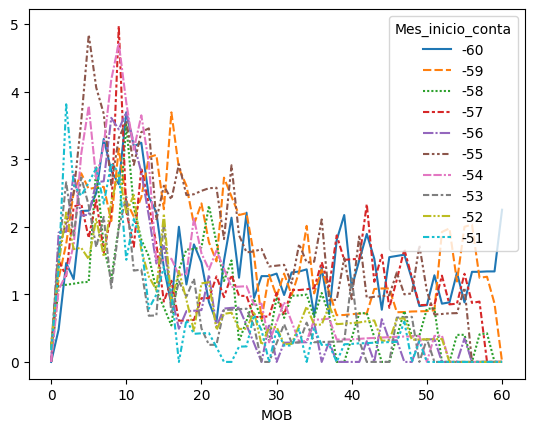

In [85]:
sns.lineplot(df_vintage_pivot.T.iloc[:, :10].fillna(0))

Percebe-se que existem mais clientes pagadores nos menores valores de MOB, ou seja, logo após abertura da conta há uma tendência dos clientes atrasarem o pagamento de dívidas.

Por outro lado, clientes com contas há mais tempo (maior MOB), geralmente são melhores pagadores.

# Criação da variável target

In [61]:
df_aprovados_pagadores.loc[df_aprovados_pagadores['ID_Cliente'] == 5001717]

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador
120,5001717,0,-21,0,21,21,1,1,0,0,0.0
121,5001717,-1,-21,0,21,20,1,1,0,0,0.0
122,5001717,-2,-21,0,21,19,1,1,0,0,0.0
123,5001717,-3,-21,0,21,18,1,1,0,0,0.0
124,5001717,-4,-21,0,21,17,1,1,0,0,0.0
125,5001717,-5,-21,0,21,16,1,2,0,0,0.0
126,5001717,-6,-21,0,21,15,1,2,0,0,0.0
127,5001717,-7,-21,0,21,14,1,2,0,0,0.0
128,5001717,-8,-21,0,21,13,1,2,0,0,0.0
129,5001717,-9,-21,0,21,12,1,2,0,0,0.0
